# Майнор по Анализу Данных, Группа ИАД-1
## Домашнее задание №4
## Деревья решений, случайный лес
## Корнеева Елизавета

<hr\>
**Общая информация**
**Срок сдачи:** 4 июня 2017, 23:59 <br\>

Сопровождайте ваш код изображеними, комментариями и выводами. <br\>
Иммейте ввиду, что на некоторые задачи нет единственного верного и полного ответа. Чем больше информации вы сможете извлечь, аргументированных выводов сформулировать, тем лучше.

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

# Classify leaf with random forest

Задание основано на Kaggle соревновании [Leaf Classification](https://www.kaggle.com/c/leaf-classification/).

Помните [Iris](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)? Данные, с которыми вам предстоит работать в этом задании концептуально похожи на ирисы.

Дана информация о 990 листьях, каждый из которых был сорван с одного из 99 видов растений.</br> 
Необходимо построить модель, которая могла бы определить, к какому растению относится каждый лист.

## Табличные данные

Загрузите файл `table_data.csv`.

В нем вы можете найти
* id - идентификатор листика
* species - столбец с названием растения (класс)
* margin, shape, texture - некоторые признаки листьев

In [2]:
DATA_DIR = os.path.join('data')
IMG_DIR = os.path.join(DATA_DIR, 'images')

In [3]:
filepath = os.path.join(DATA_DIR, 'table_data.csv')
table_data = pd.read_csv(filepath)

In [4]:
table_data.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


## Создание контрольного и обучающих множеств (1 балл)

* Задайте `random_seed`, который необходимо будет использовать при **всех** случаях использования генератора случайных чисел
* С помощью LabelEncoder закодируйте столбец `species` из исходных данных - вы должны получить одномерный numpy массив с метками классов от 0 до 98
* В переменную `X` запишите значения признаков margin, shape, texture - вы должны получить многомерный numpy массив

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
random_seed = 123

In [7]:
le = LabelEncoder()
le.fit(table_data.species)
y = le.transform(table_data.species)
X = table_data.drop(['id', 'species'],axis=1).as_matrix()


* Случайным образом разбейте данные на обучающую и контрольную выборку, причем так, чтобы в контрольной выборке содержалось по 2 объекта каждого класса.
* Сохраните индексы объектов обучающего и контрольного множеств в переменные train_idx и test_idx

#### Hint
[Это](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit) может помочь.

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

In [9]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=198, random_state=random_seed)
sss.get_n_splits(X, y)
    
for train_index, test_index in sss.split(X, y):
    X_train_init, X_test = X[train_index], X[test_index]
    y_train_init, y_test = y[train_index], y[test_index]


## Сравнение RF, DT и Bagging'а (2 балла)

На кросс-валидации по обучающей выборке сравните качество и скорость
1. Обычного дерева решений 
2. Bagging'a над деревьями решений с 10, 50, 100, 200 и 300 деревьями
3. Cлучайного леса с 10, 50, 100, 200 и 300 деревьями


* Изобразите полученные результаты на одном графике
* Используйте `StratifiedKFold` с 4 фолдами для оценки качества
* Мера качества - `accuracy`

In [43]:
import timeit

def get_accuracy(model, X_train_init, y_train_init):
    kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_seed)
    kf = kf.split(X_train_init, y_train_init)

    acc_val = []
    num_acc_val = 0
    
    times = []
    for train_index, val_index in kf: 
        X_train = X_train_init[train_index]
        X_val = X_train_init[val_index]  
    
        y_train = []
        y_val = []
        y_pred_val = []
        
        for i in range(len(train_index)):
            y_train.append(y_train_init[train_index[i]])
        
        for i in range(len(val_index)):
            y_val.append(y_train_init[val_index[i]])
            
        start_time = timeit.default_timer()
        model.fit(X_train, y_train) 
        y_pred_val = model.predict(X_val)
        times.append(timeit.default_timer() - start_time)
        
        num_acc_val = accuracy_score(y_val, y_pred_val)
        
        acc_val.append(num_acc_val)
    
    print("Time:", np.mean(times))
    return np.mean(acc_val)

In [11]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier


models = [("DT", tree.DecisionTreeClassifier())]

estimators = [10, 50, 100, 200, 300]
for estimator in estimators:
    models.append(("Bag" + str(estimator), BaggingClassifier(n_estimators=estimator, random_state=random_seed)))
for estimator in estimators:
    models.append(("RF" + str(estimator), RandomForestClassifier(n_estimators=estimator, random_state=random_seed)))

accuracies_names = []
accuracies = []

for name, model in models:
    accuracies_names.append(name)
    accuracy = get_accuracy(model, X_train_init, y_train_init)
    accuracies.append(accuracy)
    print(name, ':', accuracy)

DT : 0.607323232323
Bag10 : 0.800505050505
Bag50 : 0.914141414141
Bag100 : 0.931818181818
Bag200 : 0.945707070707
Bag300 : 0.943181818182
RF10 : 0.837121212121
RF50 : 0.965909090909
RF100 : 0.969696969697
RF200 : 0.974747474747
RF300 : 0.978535353535


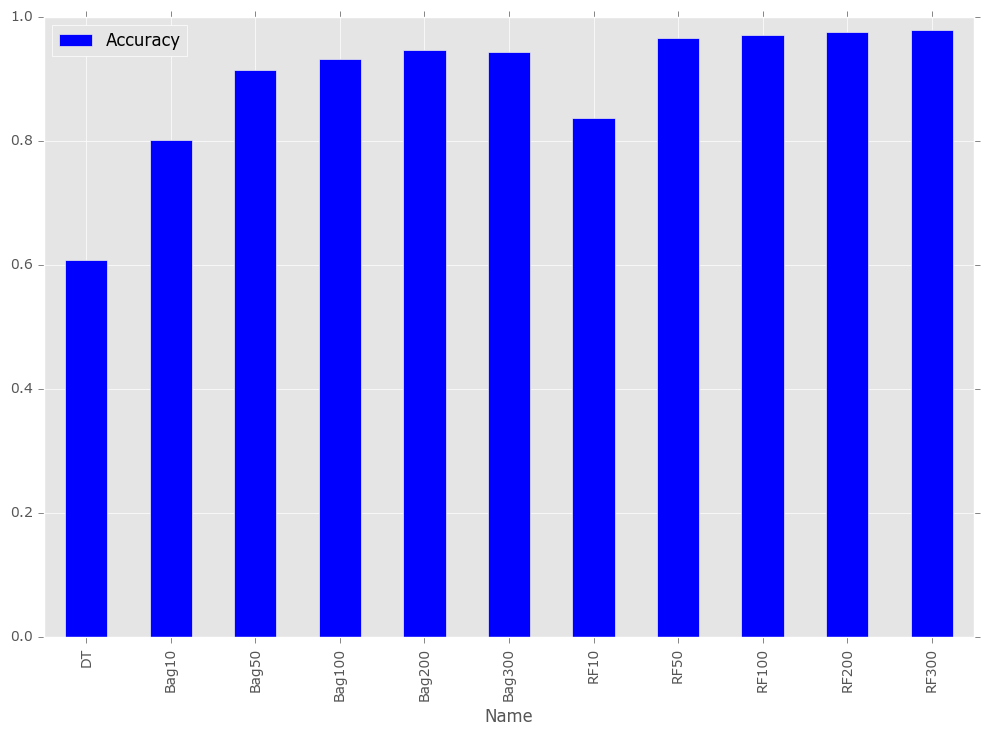

In [12]:
import matplotlib.pyplot as plt

grad = pd.DataFrame({'Name': accuracies_names,'Accuracy' : accuracies }) 
grad.plot(x='Name',kind='bar',color='b') 

# Изображения листьев

В папке `images` лежат 1584 изображения различного размера, названные в соответствии с id из файла `table_data.csv`.

In [13]:
filepath = os.path.join(IMG_DIR, '33.jpg')
img = plt.imread(filepath)

In [14]:
img.shape

(357, 700)

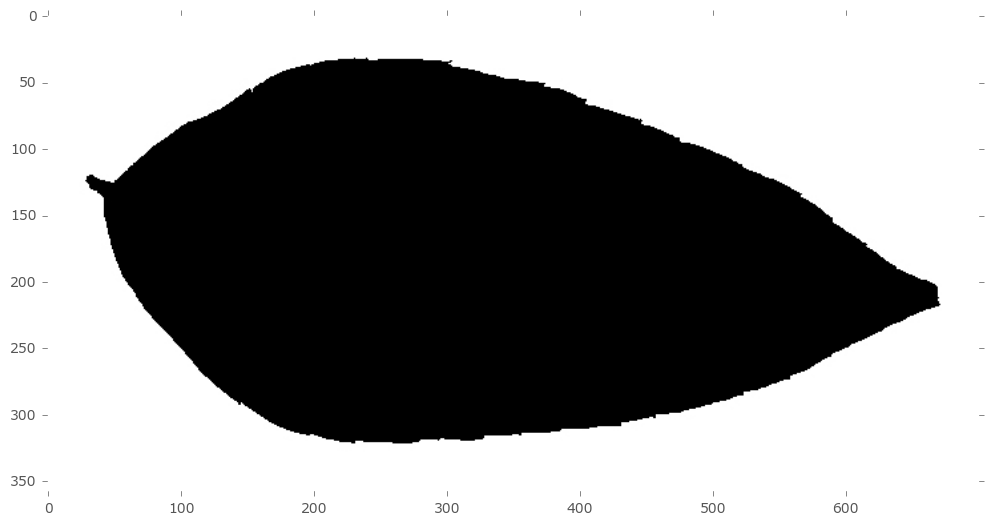

In [15]:
plt.imshow(img, cmap='Greys')
plt.grid(None)

## Загрузка изображений (1 балла)

Необходимо
1. "Стандартизировать" размер изображений - сделать его одинаковым для всех
2. Отобрать изображения тех листьев, которые представлены в `table_data`

Пункт 1. можно сделать двумя способами:
* C помощью функции scipy.misc.imresize (неидеальный вариант)
* Найти максимальные длинну и ширину полотна и перенести исходные картинки в центр (кажется, что так лучше)

В результате этого задания вы должны получить получить массив изображений IMG_train и IMG_test для обучающей и контрольной выборки.

In [16]:
from scipy.misc import imresize

In [17]:
img_resized = imresize(img, (500, 1500))

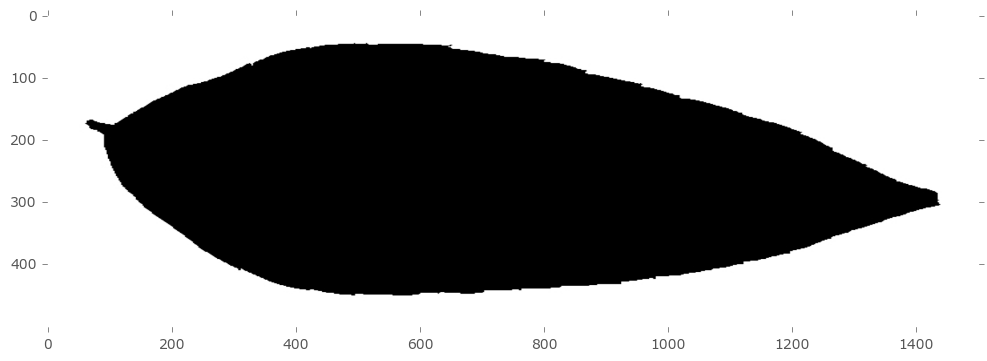

In [18]:
plt.imshow(img_resized, cmap='Greys')
plt.grid(None)

In [19]:
images = []
image_ids = list(table_data.id)

for img_id in image_ids:
    filepath = os.path.join(IMG_DIR, str(img_id) + '.jpg')
    image = plt.imread(filepath)
    images.append(imresize(image, (300, 300)))

IMG_train = np.array(images)[train_index]
IMG_test = np.array(images)[test_index]
    

## TSNE (2 балла)

* Переформатируйте IMG_train и IMG_test к виду "матрица объект-признак" (команда reshape)
* На данных в X_train и IMG_train (по отдельности) изобразите результат применения T-SNE со следующими настройками: `n_components=2, perplexity=[5,10,20,30,50], method='exact', n_iter=5000, learning_rate=500`. 
* У вас должно получится 10 `scatter-plot` графиков с точками, расскашенными в цвет своего класса (для наглядности в `plt.scatter` укажите `cmap=plt.cm.Paired`)
* В каком случае (X_train или IMG_train) кластеры выделяются лучше? Как вы думаете, почему?


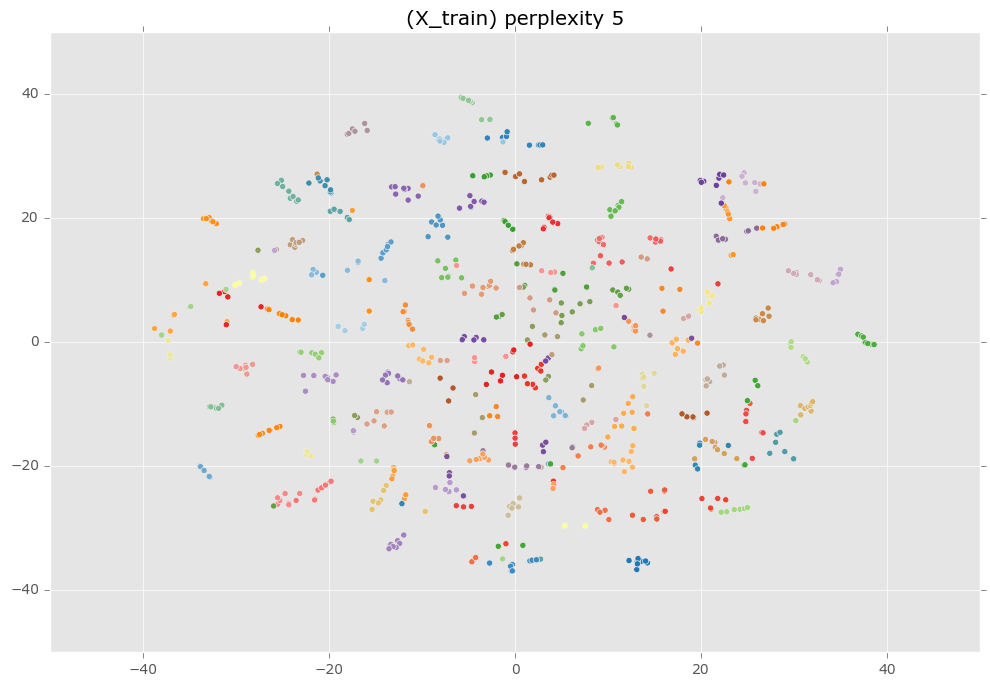

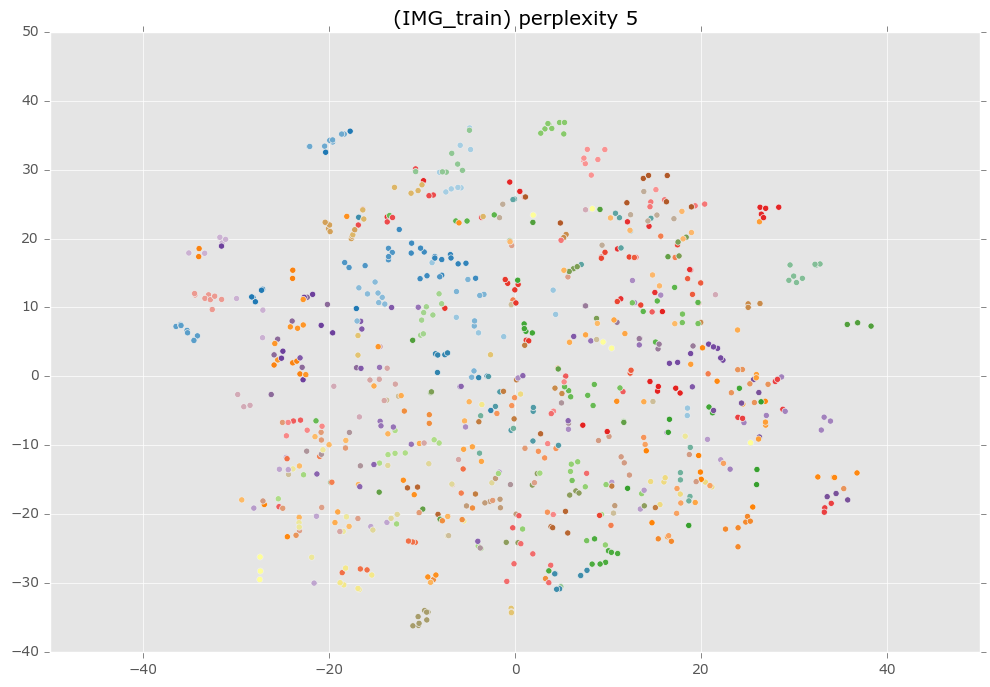

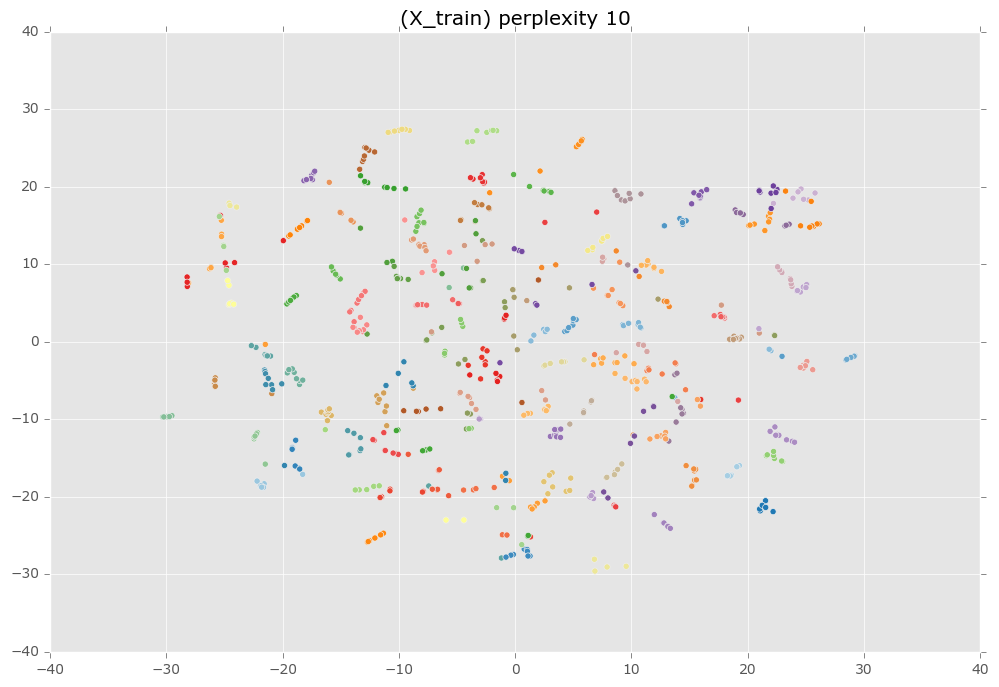

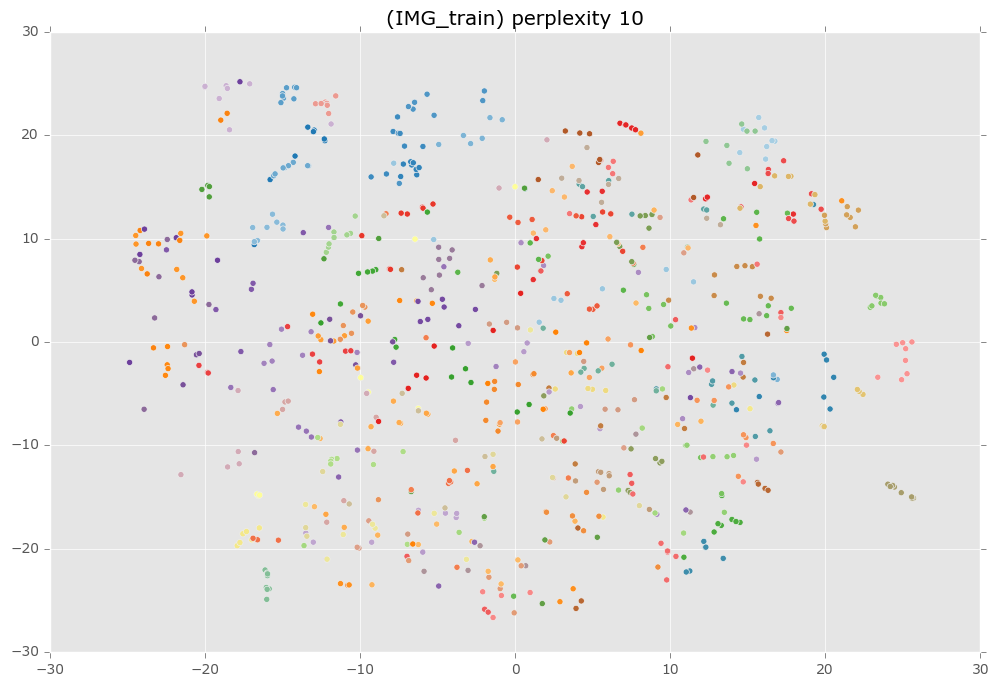

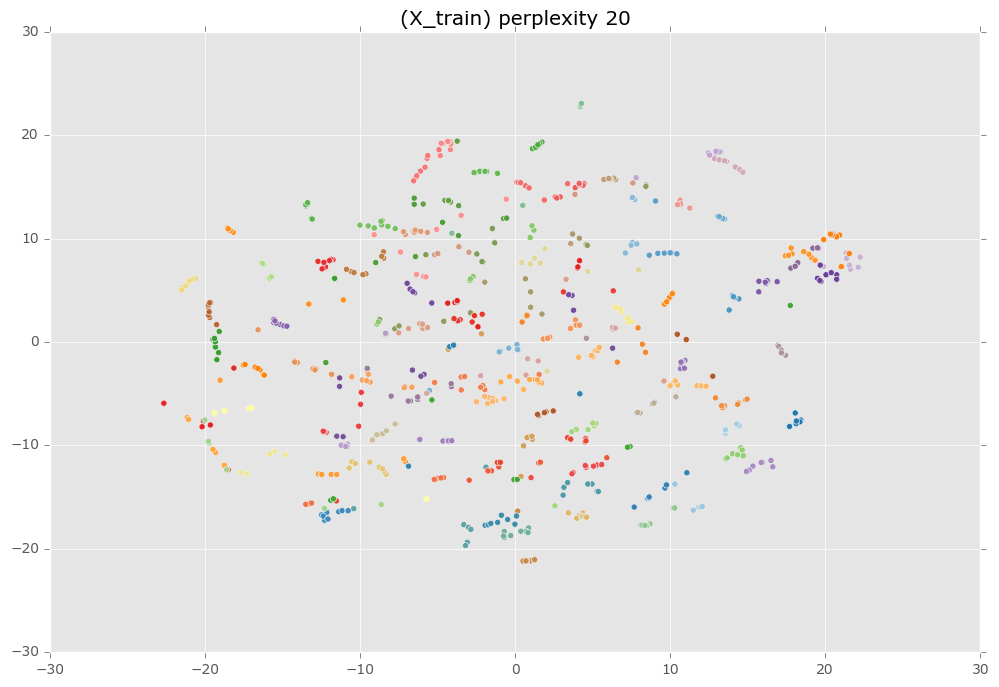

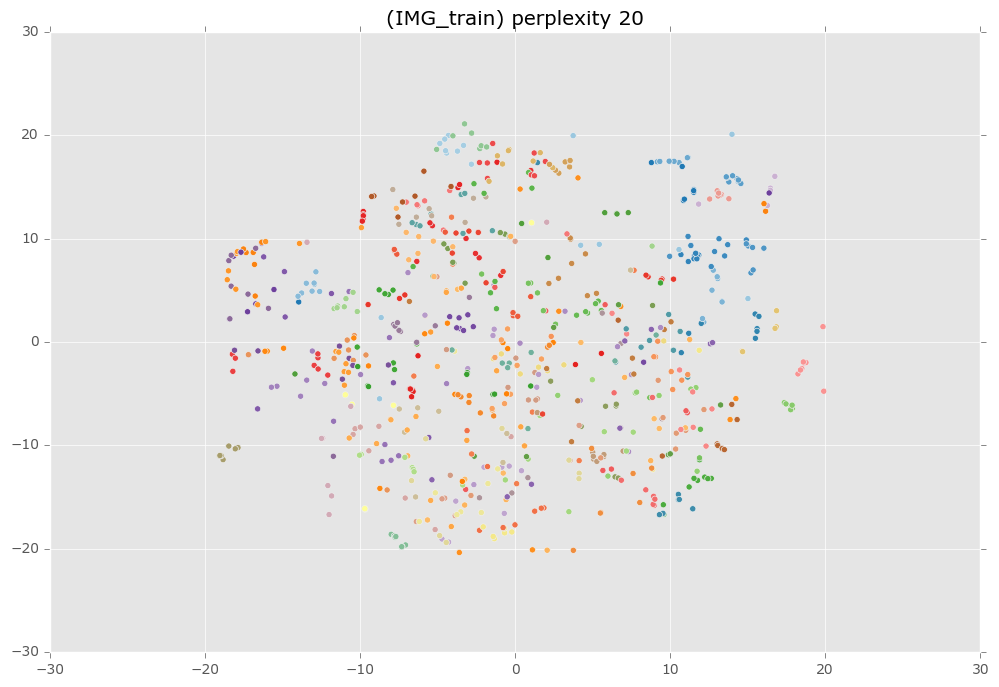

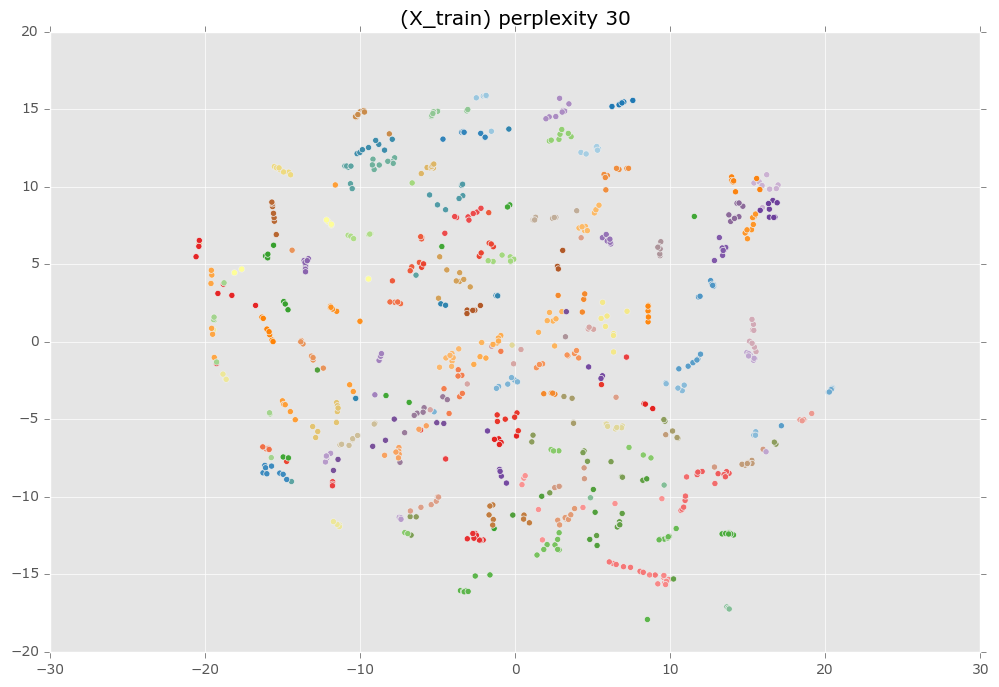

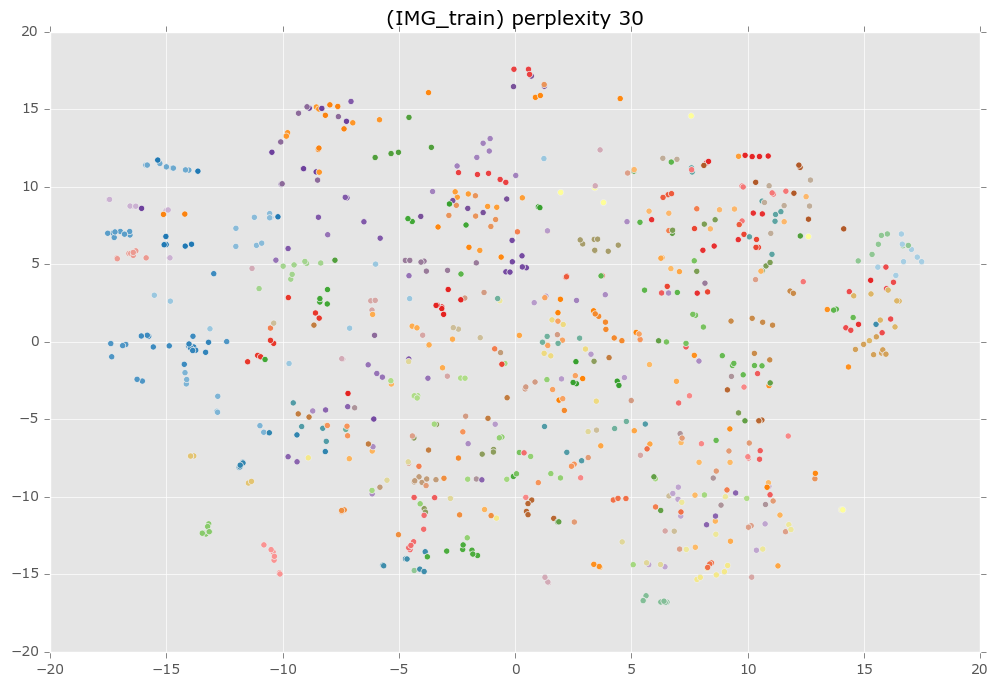

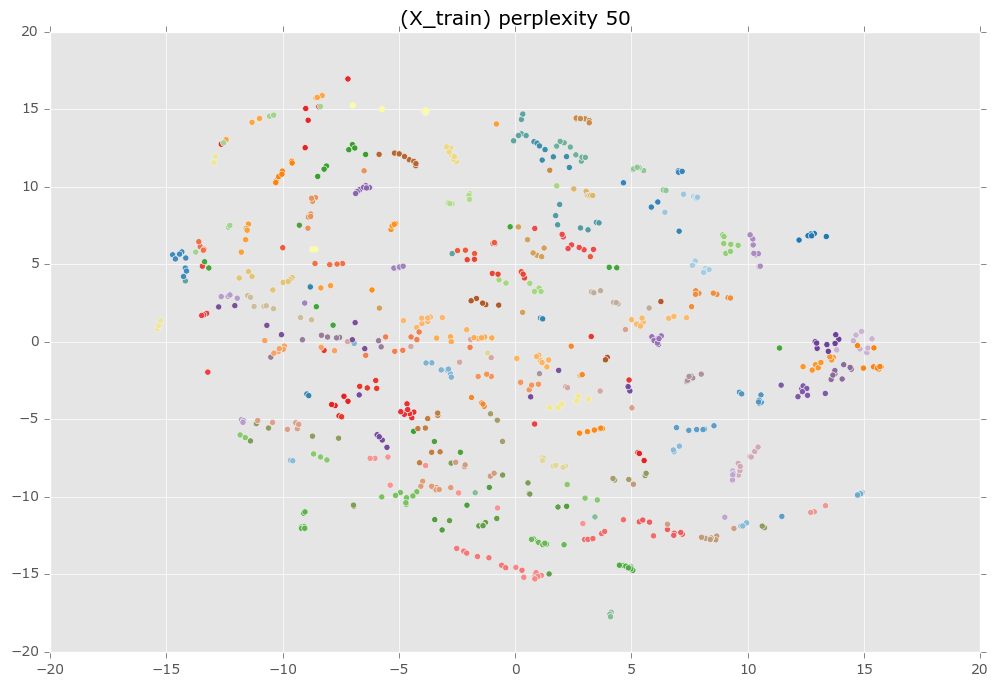

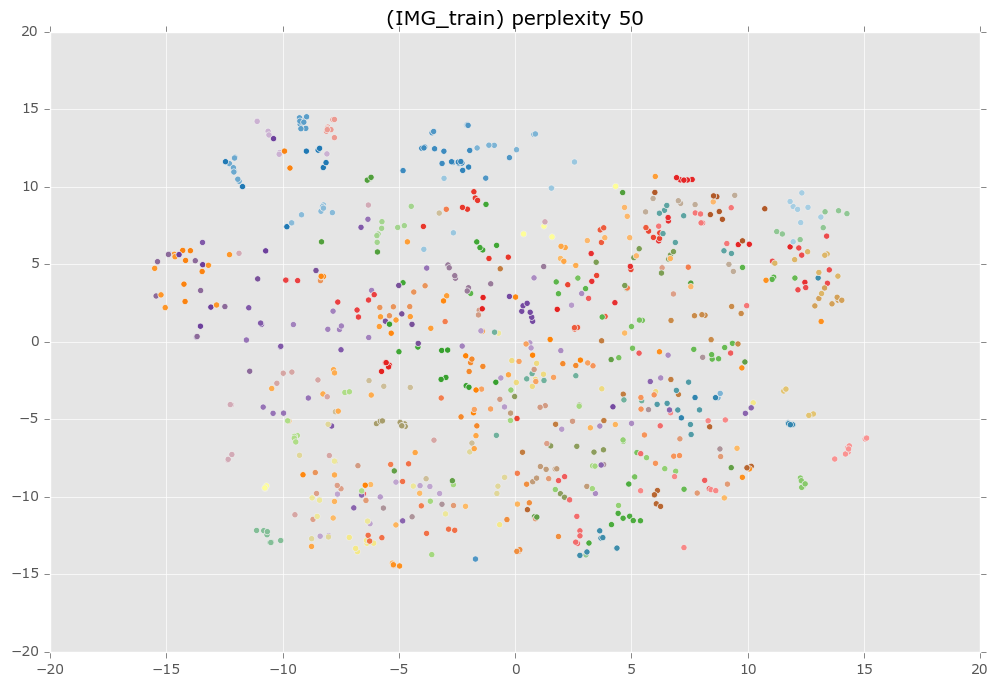

In [20]:
from sklearn.manifold import TSNE

IMG_train = IMG_train.reshape(IMG_train.shape[0],IMG_train.shape[1] * IMG_train.shape[2])
IMG_test = IMG_test.reshape(IMG_test.shape[0],IMG_test.shape[1] * IMG_test.shape[2])

perplexities = [5, 10, 20, 30, 50]
for perplexity in perplexities:
    tsne = TSNE(n_components=2, perplexity=perplexity, method='exact', n_iter=5000, learning_rate=500, random_state=random_seed)
    X_transformed = tsne.fit_transform(X_train_init)
    IMG_transformed = tsne.fit_transform(IMG_train)
    
    plt.figure()
    plt.title('(X_train) perplexity ' + str(perplexity))
    plt.scatter(X_transformed[:,0], X_transformed[:,1], c = y_train_init, cmap=plt.cm.Paired)
    
    plt.figure()
    plt.title('(IMG_train) perplexity ' + str(perplexity))
    plt.scatter(IMG_transformed[:,0], IMG_transformed[:,1], c = y_train_init, cmap=plt.cm.Paired)
    

## PCA (1 балл)

* Используйте метод главных компонент, чтобы перейти к пространству меньшей размерности. Подберите количество компонент так, чтобы доля объясненной дисперсии составляла 60%
* Используя результаты МГК на кросс-валидации сравните качество
    1. Обычного дерева решений 
    2. Bagging'a над деревьями решений с 10, 50, 100, 200 и 300 деревьями
    3. Cлучайного леса с 10, 50, 100, 200 и 300 деревьями
    
#### Hint
Составьте [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) из PCA и предиктивной модели

In [26]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

threshold = 0.6
ans = -1
diff = 1.0 

for cnt in range(10, 20):
    pca = PCA(n_components=cnt,random_state=random_seed)
    pca.fit_transform(IMG_train)
    
    disp = pca.explained_variance_ratio_.sum()
    cur_diff = np.abs(disp - threshold)
    
    if cur_diff < diff:
        ans = count
        diff = cur_diff
        best_pca = pca
        
print(ans)

15


In [29]:
from sklearn.tree import DecisionTreeClassifier
DT = Pipeline([('pca', best_pca), ('dec', DecisionTreeClassifier(random_state=random_seed))])
BG = Pipeline([('pca', best_pca), ('bag', BaggingClassifier(random_state=random_seed))])
RF = Pipeline([('pca', best_pca), ('rand', RandomForestClassifier(random_state=random_seed))])

In [44]:
DT_acc = get_accuracy(DT, IMG_train, y_train_init)

Time: 3.86259231624


In [45]:
BG_acc = []
for estimator in estimators:
    BG = Pipeline([('pca', best_pca), ('bag', BaggingClassifier(n_estimators=estimator, random_state=random_seed))])
    BG_acc.append(get_accuracy(BG, IMG_train, y_train_init))
    

Time: 3.7758308565
Time: 4.94841670399
Time: 6.20990658151
Time: 8.16361877
Time: 10.5437740305


In [46]:
RF_acc = []
for estimator in estimators:
    RF = Pipeline([('pca', best_pca), ('bag', RandomForestClassifier(n_estimators=estimator, random_state=random_seed))])
    RF_acc.append(get_accuracy(RF, IMG_train, y_train_init))
    

Time: 3.80791064449
Time: 3.96535152575
Time: 4.601408267
Time: 4.9961492215
Time: 5.43128115425


0.294191919192
[0.39015151515151514, 0.45833333333333326, 0.48611111111111105, 0.48989898989898983, 0.4861111111111111]
[0.39772727272727271, 0.48106060606060602, 0.51893939393939392, 0.51388888888888884, 0.51136363636363635]


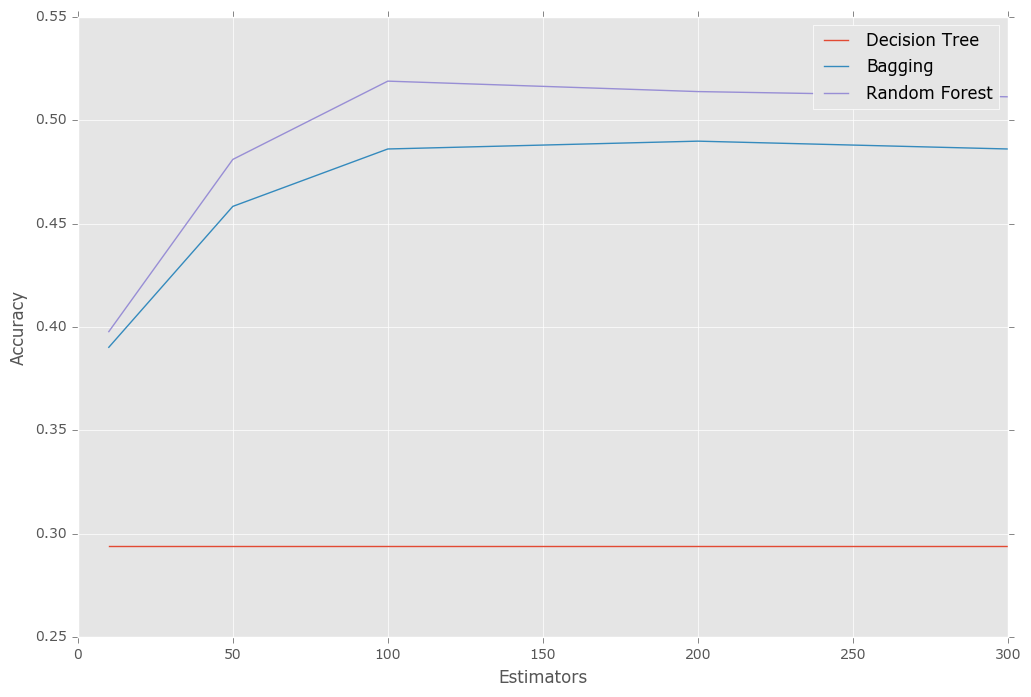

In [47]:
print("DT", DT_acc)
print("BG", *BG_acc)
print("RF", *RF_acc)
plt.plot(estimators, np.full(len(estimators), DT_acc), label = "Decision Tree")
plt.plot(estimators, BG_acc, label = 'Bagging')
plt.plot(estimators, RF_acc, label = 'Random Forest')
plt.ylabel('Accuracy')
plt.xlabel('Estimators')
plt.legend()

# Подбор гиперпараметров модели на табличных данных (2 балла)

С помощью `GridSearchCV` или `RandomizedSearchCV` подберите параметры для случайного леса

* Используйте `StratifiedKFold` на 4х фолдах
* Мера качества - `accuracy`

In [65]:
from sklearn.model_selection import GridSearchCV
params = {'n_estimators':estimators,
          'min_samples_split':[2,3,4],
          'max_features':['sqrt','log2'],
          'min_samples_leaf':[1,2],
          'max_depth':[1, 2, 3] }

RF_gridCV = GridSearchCV(RandomForestClassifier(random_state=random_seed), param_grid=params,
                                  cv=StratifiedKFold(n_splits=4, random_state=random_seed), scoring="accuracy")

In [66]:
%timeit
RF_gridCV.fit(X_train_init, y_train_init)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=123, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100, 200, 300], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2], 'max_depth': [1, 2, 3], 'max_features': ['sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [67]:
RF_gridCV.best_params_


{'max_depth': 3,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 300}

# Проверка на контрольной выборке (1 балл)

* Примените оптимальную модель на контрольной выборке
* Для нескольких случаев, где была допущена ошибка, выведите истинное изображение листа и одно из изображений листа предсказанного класса

In [70]:
prediction = RF_gridCV.predict(X_test)

print("Accuracy:",  accuracy_score(y_test, prediction))

Accuracy: 0.808080808081


In [78]:
table_data.loc[test_index].loc[y_test != prediction].head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
118,214,Magnolia_Heptapeta,0.082031,0.148440,0.009766,0.001953,0.000000,0.146480,0.000000,0.000000,...,0.161130,0.0,0.075195,0.000000,0.003906,0.0,0.0,0.000000,0.000000,0.005859
511,825,Quercus_Castaneifolia,0.021484,0.017578,0.021484,0.005859,0.013672,0.021484,0.058594,0.000000,...,0.001953,0.0,0.016602,0.000000,0.017578,0.0,0.0,0.001953,0.009766,0.117190
625,992,Callicarpa_Bodinieri,0.003906,0.007812,0.023438,0.066406,0.050781,0.029297,0.001953,0.003906,...,0.000000,0.0,0.000000,0.003906,0.008789,0.0,0.0,0.000977,0.079102,0.000000
463,757,Cornus_Controversa,0.054688,0.103520,0.013672,0.003906,0.000000,0.099609,0.017578,0.000000,...,0.000000,0.0,0.026367,0.000000,0.012695,0.0,0.0,0.000000,0.013672,0.000977
375,619,Lithocarpus_Edulis,0.060547,0.162110,0.021484,0.003906,0.001953,0.234380,0.000000,0.000000,...,0.055664,0.0,0.036133,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [79]:
len(table_data.loc[test_index].loc[y_test != prediction])

38

In [80]:
print("Prediction indexes:", *prediction[y_test != prediction][:3])

Prediction indexes: 38 65 91


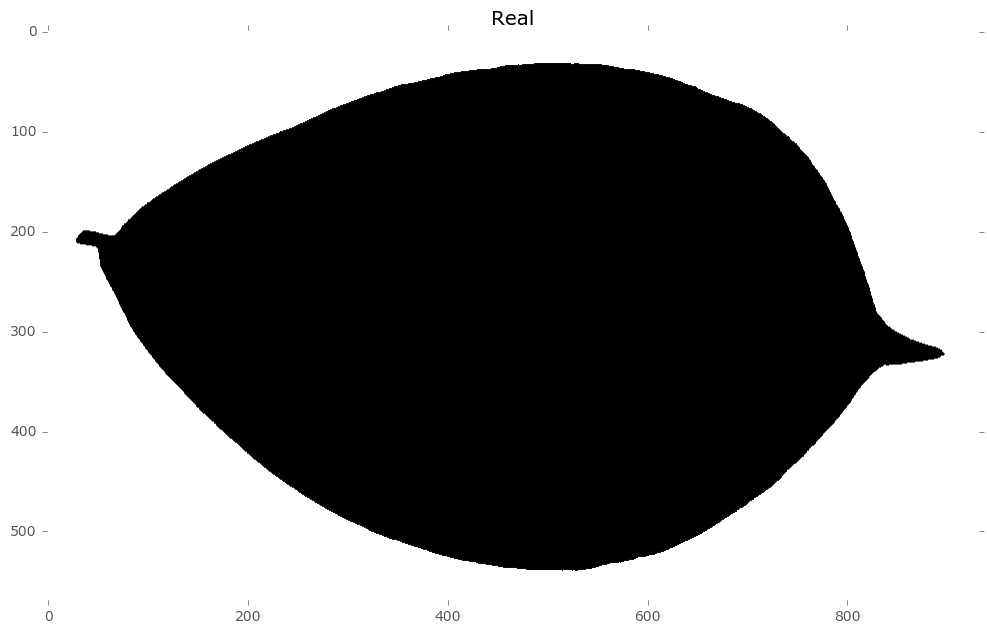

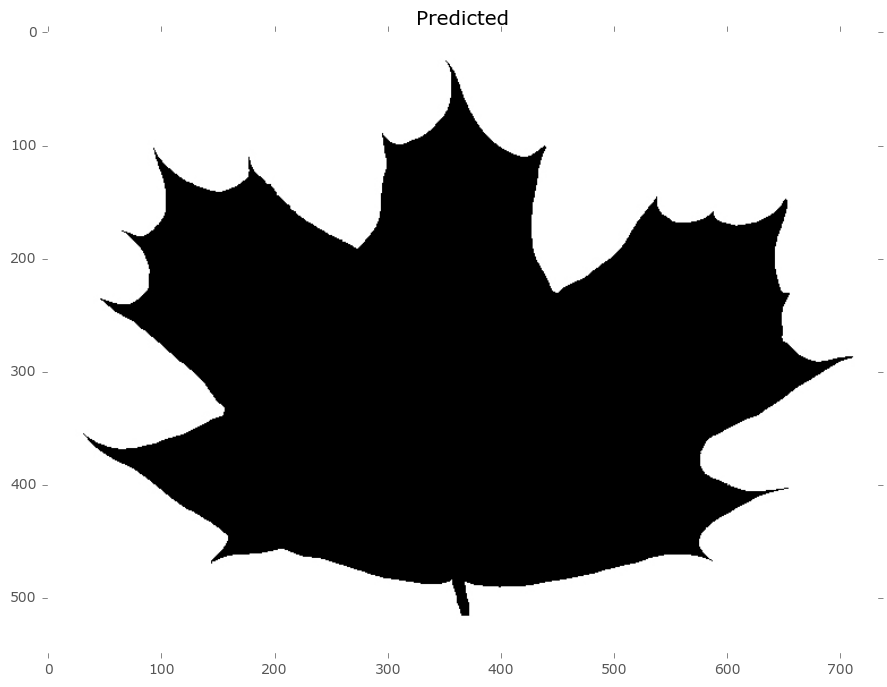

In [81]:
img = plt.imread(os.path.join(IMG_DIR, '214.jpg') )
plt.imshow(img, cmap = 'Greys')
plt.grid(False)
plt.title('Real')
plt.show()

img = plt.imread(os.path.join(IMG_DIR, '38.jpg') )
plt.imshow(img, cmap = 'Greys')
plt.grid(False)
plt.title('Predicted')
plt.show()

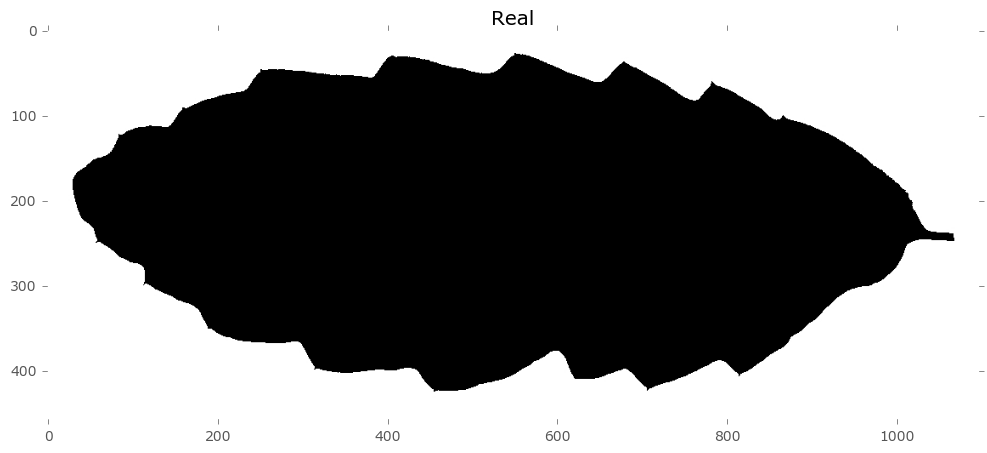

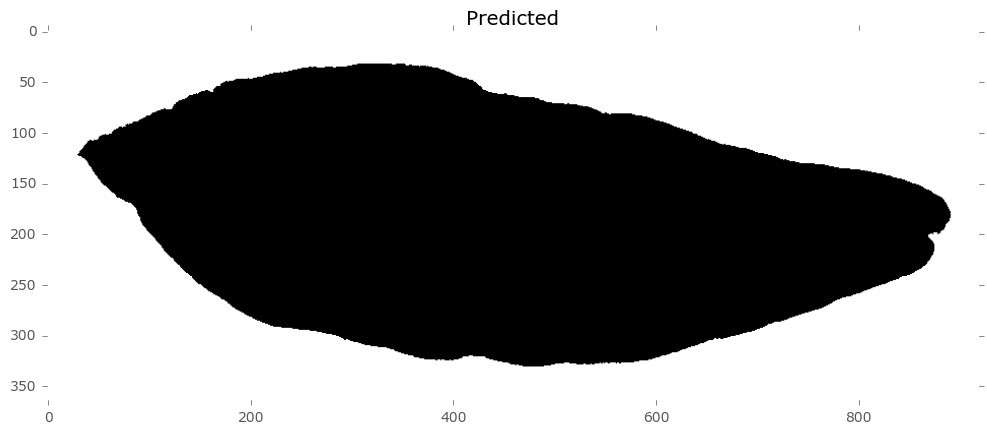

In [82]:
img = plt.imread(os.path.join(IMG_DIR, '825.jpg') )
plt.imshow(img, cmap = 'Greys')
plt.grid(False)
plt.title('Real')
plt.show()

img = plt.imread(os.path.join(IMG_DIR, '65.jpg') )
plt.imshow(img, cmap = 'Greys')
plt.grid(False)
plt.title('Predicted')
plt.show()

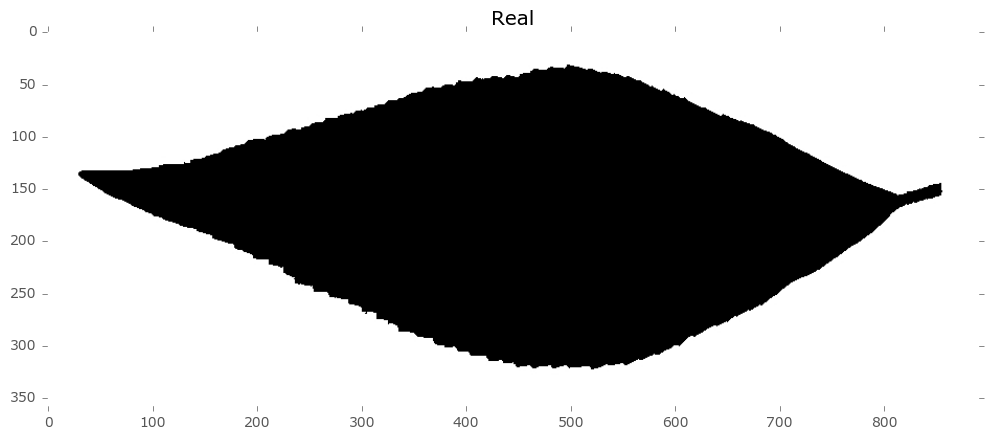

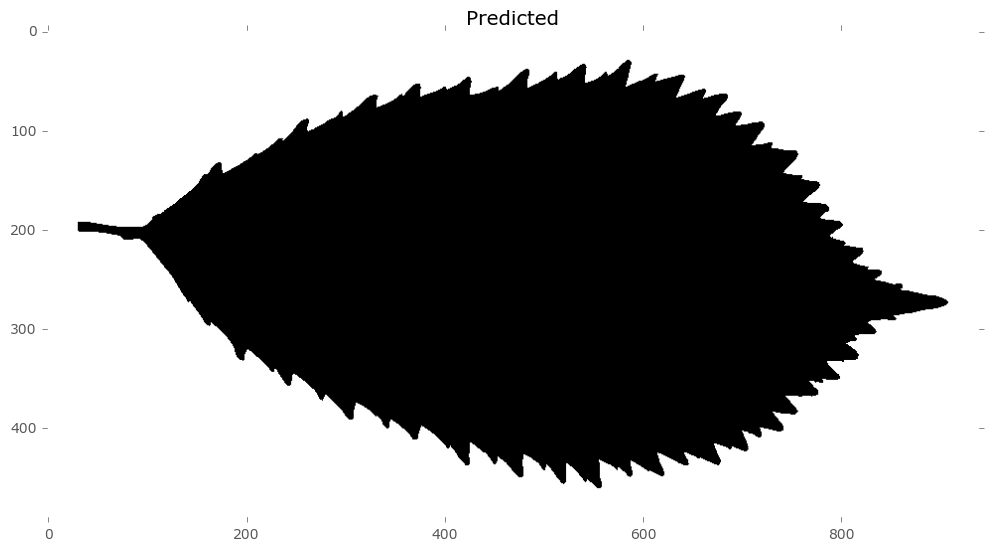

In [83]:
img = plt.imread(os.path.join(IMG_DIR, '992.jpg') )
plt.imshow(img, cmap = 'Greys')
plt.grid(False)
plt.title('Real')
plt.show()

img = plt.imread(os.path.join(IMG_DIR, '91.jpg') )
plt.imshow(img, cmap = 'Greys')
plt.grid(False)
plt.title('Predicted')
plt.show()

# Подбор гиперпараметров модели на объединенных данных (2 балла) **

За это задание можно получить 2 дополнительных балла, но сделать его надо безукоризненно =)

Сейчас мы попробуем использовать данные с изображений и табличные данные, которые затем пойдут на вход случайному лесу. Далее надо будет подобрать оптимальные гиперпараметры случайного леса с помощью кросс-валидации

## Объединяем данные

* Составьте матрицу A_train (A_test) как результаты конкатенации матриц X_train и IMG_train (X_test и IMG_test)

In [ ]:
# Your Code Here

## Составим  Pipeline

Наш Pipeline условно изображен на рисунке ниже:

<center><img src='scheme.png'></center>


Из объединенных данных в матрице `А` 
1. Выбираются столбцы, которые относятся к изображению и передаются в `PCA`
2. Исходные табличные данные отделяются от всех остальных, но остаются без изменений
3. Результаты пунктов 1 и 2 объединяются
4. И передаются на вход в случайный лес

В результате в переменную model вы должны записать весь Pipeline из шагов 1-4

#### Hints
* Для того, чтобы выбирать столбцы из матрицы `А` можно использовать `FunctionTransformer` (см. пример ниже)
* Для того, чтобы объединять результаты преобразований можно использовать [`FeatureUnion`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html)

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

In [ ]:
def select_col_idx(X, col_idx=[1]):
    return X[:, col_idx]

In [ ]:
trans = FunctionTransformer(select_col_idx, kw_args={'col_idx': [2,3]})

In [ ]:
trans.fit_transform(A_train)

In [ ]:
# Your Code Here

## Проверка на контрольной выборке

* Примените оптимальную модель на контрольной выборке
* Сравните качество с моделью на табличных данных

In [ ]:
# Your Code Here